# Testing on more counties


##### Notebook summary
After doing testing on data from a large number of counties, we observed that 

{'smoothing_arima_mult_120': 0.39626066666666665,  
 'arima': 0.4626084444444445,  
 'expsmoothing_predict': 0.7057506666666666,  
 'naive_predict': 1.0,  
 'prophet_arima_mult_120': 2.201474111111111,  
 'prophet_arima_withlockdown_mult_120': 2.366923111111111,  
 'prophet_predict_withlockdown': 3.6464730000000003,  
 'constant_predict': 4.015258666666666}  

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
from seaborn import set_style
from sklearn.preprocessing import MinMaxScaler
set_style=("whitegrid")

#### Preprocessing

We save the MinMaxScaler objects so that when we evaluate the models later we can undo the normalization for context. 

In [ ]:
import preprocessing
importlib.reload(preprocessing)
#create dataframe from county 0JTMM, 2018-2022
#the csv files have all data in a single column, so we need to separate them using the delimiter
countydict = {}
scalerdict = {}
rowsdict = {}
for i in range(2018, 2024):
    df=pd.read_csv('../data/eTimes03.eDispatch01/pub_data_'+str(i)+'_counties.csv',header=None, delimiter="|")
    #properly label columns 
    df=df.rename(columns={0:'PcrKey',1: 'county', 2:'eTimes_03',3:'eDispatch_01'})        
        
    #create data: stores the number of calls each day
    counties = df.county.unique()
    
    for county in counties:
        if county not in countydict.keys():
            countydict[county]=[]
            scalerdict[county]=[]
            rowsdict[county]=0
        countydf = df[df['county']==county]
        rowsdict[county]=rowsdict[county]+countydf.shape[0]
        data, scaler = preprocessing.get_processed_series(countydf)
        countydict[county].append(data.copy())

for county in countydict:
    countydict[county]=pd.concat(countydict[county], ignore_index=True)
    


#### Put 90 percent of the data into the training set

In [6]:
import preprocessing
traindict={}
testdict={}
for county in countydict:
    traindict[county], testdict[county]=preprocessing.time_series_split(countydict[county], .9)


In [ ]:
import forecasting
importlib.reload(forecasting)
from forecasting import prophet_predict, expsmoothing_predict, prophet_predict_withlockdown
params = {
    'type': ['mult', 'add'],
    'window': [30, 60, 90]
}
seven_dict={}
for county in traindict:
    seven_dict[county]=forecasting.ttsplit_predictions(traindict[county], 1, 7, extra_models=[prophet_predict, prophet_predict_withlockdown,expsmoothing_predict], printprogress=True, do_arima=True, smoothing_params=params, fixed_residue_models=True)


#### Preliminary Testing to Evaluate Hyperparameters

In [39]:
from forecasting import evaluate_predictions, holdout_values
for county in traindict:
    for model in seven_dict[county]:
        seven_dict[county][model]=np.nan_to_num(seven_dict[county][model][-7:])
    print(forecasting.evaluate_predictions(holdout_values(traindict[county].fillna(0), 1,7), seven_dict[county]).sort_values(by='NMSE').head)


<bound method NDFrame.head of                                  Model       MSE       MAE      NMSE
2                     constant_predict  0.022694  0.134202  0.064989
4         prophet_predict_withlockdown  0.024294  0.154920  0.069569
3                      prophet_predict  0.025724  0.159600  0.073663
18              smoothing_arima_add_60  0.027081  0.164501  0.077551
9              smoothing_arima_mult_60  0.027508  0.165846  0.078773
15              smoothing_arima_add_30  0.027614  0.166171  0.079076
6              smoothing_arima_mult_30  0.027978  0.167260  0.080118
16                prophet_arima_add_30  0.028626  0.169113  0.081974
7                prophet_arima_mult_30  0.029014  0.170218  0.083086
0                                arima  0.030363  0.173630  0.086948
17   prophet_arima_withlockdown_add_30  0.031304  0.176090  0.089644
8   prophet_arima_withlockdown_mult_30  0.031792  0.177230  0.091041
19                prophet_arima_add_60  0.033076  0.179695  0.094719
10  

#### Testing on counties that are not missing days. (These are what the neural networks code is tested on.)

In [55]:
complete_counties = ['7AA9Y', 'HKHZQ', 'B2C2S', 'UPAPQ', 'ERY72', '7WC4T', 'FRK94', 'LGYAG', 'MXY0O', '8MKQ8', 'PAHPY']

In [ ]:
import forecasting
importlib.reload(forecasting)
from forecasting import prophet_predict, expsmoothing_predict, prophet_predict_withlockdown
params = {
    'type': ['mult'],
    'window': [60]
}
results_dict={}
for county in complete_counties:
    print(county)
    results_dict[county]=forecasting.ttsplit_predictions(traindict[county], 5, 7, extra_models=[prophet_predict, prophet_predict_withlockdown,expsmoothing_predict], printprogress=True, do_arima=True, smoothing_params=params, fixed_residue_models=True)


#### Testing seven day forecast horizons for the complete counties. 

In [60]:
for county in results_dict:
    print(forecasting.evaluate_predictions(holdout_values(traindict[county].fillna(0), 5,7), results_dict[county]).sort_values(by='NMSE'))


                                Model       MSE       MAE      NMSE
6             smoothing_arima_mult_60  0.010703  0.083973  0.135173
8  prophet_arima_withlockdown_mult_60  0.011182  0.081510  0.141219
7               prophet_arima_mult_60  0.012612  0.087558  0.159285
0                               arima  0.012751  0.091619  0.161036
4        prophet_predict_withlockdown  0.015977  0.098390  0.201784
3                     prophet_predict  0.028191  0.128608  0.356036
5                expsmoothing_predict  0.059692  0.185602  0.753868
2                    constant_predict  0.072457  0.246844  0.915085
1                       naive_predict  0.079181  0.196512  1.000000
                                Model       MSE       MAE      NMSE
0                               arima  0.003394  0.049913  0.355960
6             smoothing_arima_mult_60  0.003901  0.052545  0.409150
8  prophet_arima_withlockdown_mult_60  0.006319  0.064578  0.662834
5                expsmoothing_predict  0.008854 

In [ ]:
import forecasting
importlib.reload(forecasting)
from forecasting import prophet_predict, expsmoothing_predict, prophet_predict_withlockdown
params = {
    'type': ['mult'],
    'window': [60]
}
results_dict={}
for county in complete_counties:
    print(county)
    results_dict[county]=forecasting.ttsplit_predictions(traindict[county], 5, 14, extra_models=[prophet_predict, prophet_predict_withlockdown,expsmoothing_predict], printprogress=True, do_arima=True, smoothing_params=params, fixed_residue_models=True)


#### Testing fourteen day forecast horizons for the complete counties. 

In [126]:
rdf= pd.DataFrame(['county', 'result'])
for county in results_dict:
    if county in traindict:
        print(forecasting.evaluate_predictions(holdout_values(traindict[county].fillna(0), 5,14), results_dict[county]).sort_values(by='NMSE'))
        

                                Model       MSE       MAE      NMSE
6             smoothing_arima_mult_60  0.011131  0.081877  0.119655
7               prophet_arima_mult_60  0.011685  0.084938  0.125616
4        prophet_predict_withlockdown  0.014194  0.093822  0.152590
0                               arima  0.016264  0.103601  0.174838
8  prophet_arima_withlockdown_mult_60  0.017324  0.107583  0.186229
3                     prophet_predict  0.027336  0.125585  0.293861
5                expsmoothing_predict  0.066239  0.193732  0.712066
2                    constant_predict  0.077406  0.260647  0.832116
1                       naive_predict  0.093024  0.222600  1.000000
                                Model       MSE       MAE      NMSE
3                     prophet_predict  0.006379  0.065248  0.156801
4        prophet_predict_withlockdown  0.007312  0.068753  0.179737
0                               arima  0.009518  0.078854  0.233983
8  prophet_arima_withlockdown_mult_60  0.009614 

#### Load some more randomly selected counties. 

In [ ]:
countydict2 = {}
scalerdict2 = {}
rowsdict2 = {}
for i in range(2018, 2024):
    df=pd.read_csv('../../eTimes03.eDispatch01/pub_data_counties_'+str(i)+'_batch2.csv/pub_data_counties_'+str(i)+'_batch2.csv',header=None, delimiter="|")
    #properly label columns 
    df=df.rename(columns={0:'PcrKey',1: 'county', 2:'eTimes_03',3:'eDispatch_01'})        
    counties = df.county.unique()
    
    for county in counties:
        if county not in countydict2.keys():
            countydict2[county]=[]
            scalerdict2[county]=[]
            rowsdict2[county]=0
        countydf = df[df['county']==county]
        rowsdict2[county]=rowsdict2[county]+countydf.shape[0]
        data, scaler = preprocessing.get_processed_series(countydf)
        countydict2[county].append(data.copy())
        scalerdict2[county].append(scaler)

for county in countydict2:
    countydict2[county]=pd.concat(countydict2[county], ignore_index=True)


In [73]:
import forecasting
contains_most_dates = []
for county in countydict2:
    if countydict2[county].shape[0]>2000:
        contains_most_dates.append(county)
train_dict2={}
test_dict2={}
for county in contains_most_dates:
    train_dict2[county], test_dict2[county]=preprocessing.time_series_split(countydict2[county],train_ratio=.9)

In [ ]:
import forecasting
importlib.reload(forecasting)
from forecasting import prophet_predict, expsmoothing_predict, prophet_predict_withlockdown
params = {
    'type': ['mult'],
    'window': [60]
}
results_dict={}
for county in train_dict2:
    print(county)
    results_dict[county]=forecasting.ttsplit_predictions(train_dict2[county], 5, 14, extra_models=[prophet_predict, prophet_predict_withlockdown,expsmoothing_predict], printprogress=True, do_arima=True, smoothing_params=params, fixed_residue_models=True)


#### Train-test split. Results are sorted by the total number of calls in each county in the training data. 
Data has been rescaled to undo the normalization, so the mean average error represents the average of number of calls that each prediction was off by.   
Models do not perform well on counties that have fewer than 150,000 calls in the period of time represented in the training data. 

In [130]:
sorted_dict_desc = dict(sorted(rowsdict2.items(), key=lambda item: item[1], reverse=True))
results = {}
for county in sorted_dict_desc:
    if county in results_dict:
        print(county)
        print(str(rowsdict2[county]))
        scaler=scalerdict2[county][-1]
        av=holdout_values(train_dict2[county].fillna(0), 5,14).reshape(-1,1)
        av=scaler.inverse_transform(av)
        preds={}
        for model in results_dict[county]:
            preds[model]=scaler.inverse_transform(results_dict[county][model].reshape(-1,1))
        results[county]=forecasting.evaluate_predictions(av, preds).sort_values(by='MAE')
        print(results[county])

7AA9Y
4614204
                                Model            MSE         MAE      NMSE
6             smoothing_arima_mult_60   29283.611901  132.805155  0.119655
7               prophet_arima_mult_60   30742.450592  137.770050  0.125616
4        prophet_predict_withlockdown   37343.946387  152.179468  0.152590
0                               arima   42788.749823  168.040966  0.174838
8  prophet_arima_withlockdown_mult_60   45576.571056  174.500353  0.186229
3                     prophet_predict   71917.801902  203.698900  0.293861
5                expsmoothing_predict  174266.909965  314.233993  0.712066
1                       naive_predict  244734.342857  361.057143  1.000000
2                    constant_predict  203647.331807  422.770089  0.832116
PFR55
3324626
                                Model            MSE         MAE      NMSE
8  prophet_arima_withlockdown_mult_60   21053.651127  114.231824  0.108883
0                               arima   21837.577630  117.850475  0.1129

In [147]:
print(results['0JTMM']['Model'][6])

smoothing_arima_mult_60


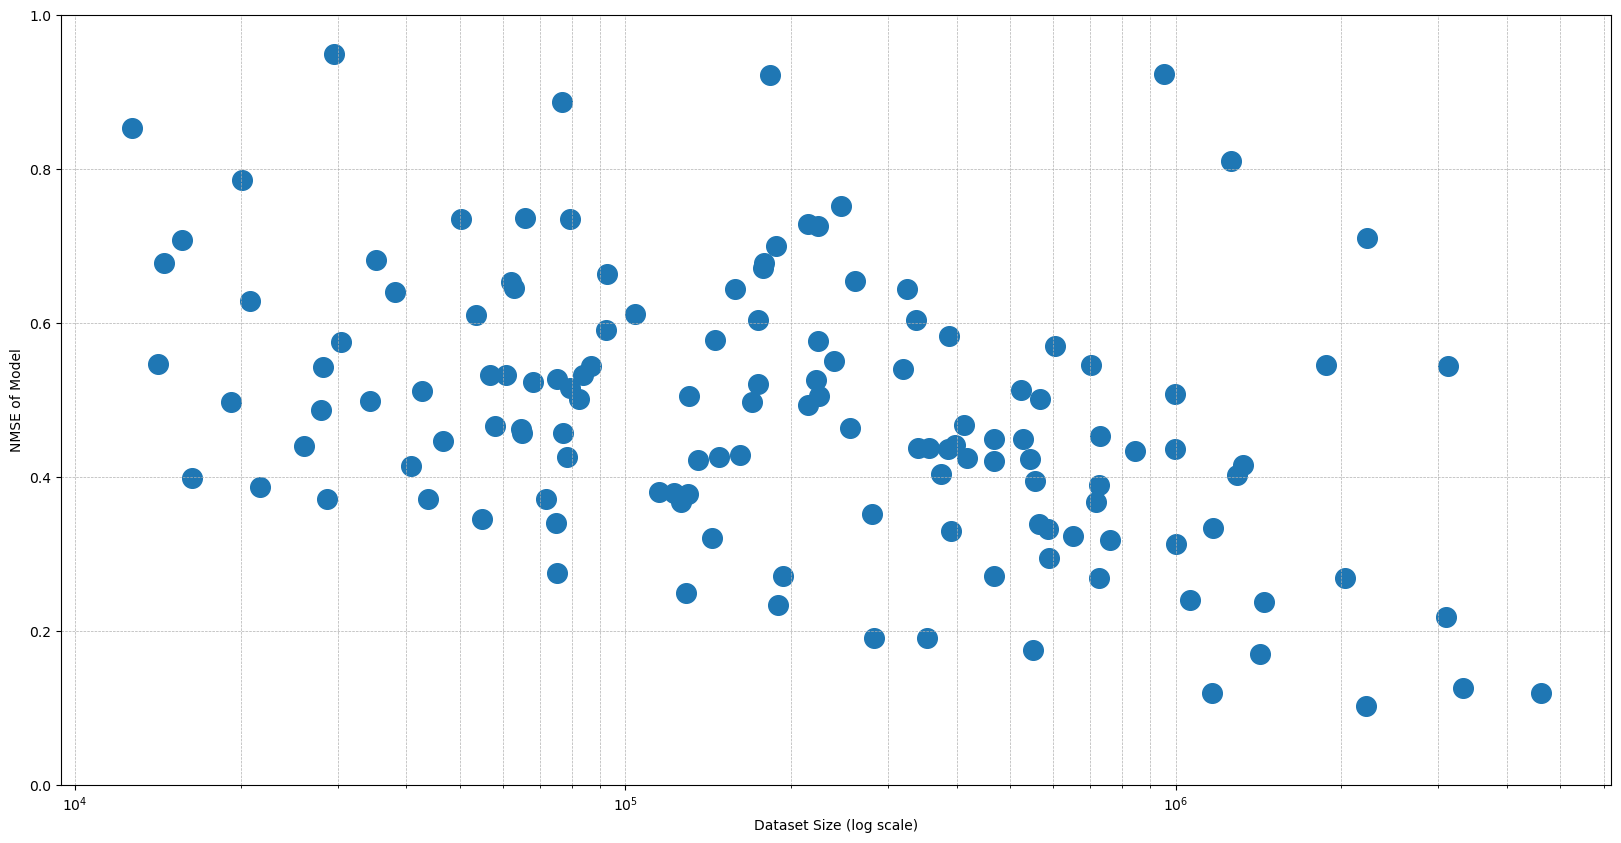

In [150]:
df = pd.DataFrame(columns=['Dataset_Size', 'NMSE'])

for county in results:
    df.loc[len(df)] = [rowsdict2[county], results[county]['NMSE'][6]]

# Sort data by Dataset_Size for cleaner plotting
df = df.sort_values(by='Dataset_Size')

plt.figure(figsize=(20, 10))
plt.scatter(df['Dataset_Size'], df['NMSE'], s=200, marker='o')  # Use scatter and increase marker size
plt.xlabel('Dataset Size (log scale)')
plt.ylabel('NMSE of Model')
ax = plt.gca()
ax.set_xscale('log')
plt.ylim(0, 1)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # Add grid for better readability
plt.show()


#### Select the 10 largest datasets for final testing. 

In [82]:
test_counties = list(sorted_dict_desc.keys())[:10]


#### Official Testing on Test Set
Since 10*14 is smaller than the length of the test set, we just pull the testing data from the original data frame for convenience. No training was ever done on the dates we try to predict here. 

In [ ]:
import forecasting
importlib.reload(forecasting)
from forecasting import  prophet_predict_withlockdown

final_dict={}
for county in test_counties:
    if county in train_dict2:
        print(county)
        final_dict[county]=forecasting.ttsplit_predictions(countydict2[county], 10, 14, extra_models=[prophet_predict_withlockdown], printprogress=False, do_arima=True)


In [88]:
for county in final_dict:
    print(county)
    print(str(rowsdict2[county]))
    scaler=scalerdict2[county][-1]
    av=holdout_values(countydict2[county].fillna(0), 10,14).reshape(-1,1)
    av=scaler.inverse_transform(av)
    preds={}
    for model in final_dict[county]:
        preds[model]=scaler.inverse_transform(final_dict[county][model].reshape(-1,1))
    print(forecasting.evaluate_predictions(av, preds).sort_values(by='MAE'))


7AA9Y
4614204
                          Model            MSE         MAE      NMSE
3  prophet_predict_withlockdown   70227.379087  199.936549  0.183200
0                         arima  124313.775620  246.129477  0.324294
2              constant_predict  164891.199518  369.624040  0.430147
1                 naive_predict  383336.828571  530.071429  1.000000
PFR55
3324626
                          Model            MSE         MAE      NMSE
0                         arima  473555.520116  362.999100  0.950951
2              constant_predict  281395.964548  415.897557  0.565073
3  prophet_predict_withlockdown  439850.004312  464.455528  0.883266
1                 naive_predict  497981.242842  488.710758  1.000000
HKHZQ
3132673
                          Model            MSE         MAE      NMSE
0                         arima   78391.637525  152.421634  1.012004
1                 naive_predict   77461.800000  178.900000  1.000000
3  prophet_predict_withlockdown  578567.800506  700.410744  7

In [ ]:
models=['prophet_predict_withlockdown', 'arima', 'constant_predict', 'naive_predict']
for county in test_counties:
    if county in results_dict:
        print(county)
        print(str(rowsdict2[county]))
        scaler=scalerdict2[county][-1]
        av=holdout_values(train_dict2[county].fillna(0), 5,14).reshape(-1,1)
        av=scaler.inverse_transform(av)
        preds={}
        for model in results_dict[county]:
            preds[model]=scaler.inverse_transform(results_dict[county][model].reshape(-1,1))
        print(forecasting.evaluate_predictions(av, preds).sort_values(by='MAE'))


In [ ]:
import forecasting
importlib.reload(forecasting)
params = {
    'type': ['mult'],
    'window': [120]
}

final_dict2={}
for county in test_counties:
    if county in train_dict2:
        print(county)
        final_dict2[county]=forecasting.ttsplit_predictions(countydict2[county], 10, 14, fixed_residue_models=True,smoothing_params=params, printprogress=False, do_arima=False)


In [117]:
smoothing_dict={}
from forecasting import expsmoothing_predict
for county in final_dict2:
    print(county)
    smoothing_dict[county]=forecasting.ttsplit_predictions(countydict2[county], 10, 14, extra_models=[expsmoothing_predict], printprogress=False, do_arima=False)


7AA9Y
PFR55
HKHZQ
FIHD3
NTVRU
B2C2S
9ERGC
JF1T1
T5KTW


#### Final Results (from best to worse).
{'smoothing_arima_mult_120': 0.39626066666666665,   
 'arima': 0.4626084444444445,   
 'expsmoothing_predict': 0.7057506666666666,   
 'naive_predict': 1.0,   
 'prophet_arima_mult_120': 2.201474111111111,  
 'prophet_arima_withlockdown_mult_120': 2.366923111111111,   
 'prophet_predict_withlockdown': 3.6464730000000003,   
 'constant_predict': 4.015258666666666}   


In [122]:
for county in final_dict2:
    print(county)
    print(str(rowsdict2[county]))
    scaler=scalerdict2[county][-1]
    av=holdout_values(countydict2[county].fillna(0), 10,14).reshape(-1,1)
    av=scaler.inverse_transform(av)
    preds={}
    for model in final_dict2[county]:
        preds[model]=scaler.inverse_transform(final_dict2[county][model].reshape(-1,1))
    for model in final_dict[county]:
        preds[model]=scaler.inverse_transform(final_dict[county][model].reshape(-1,1))
    for model in smoothing_dict[county]:
        preds[model]=scaler.inverse_transform(smoothing_dict[county][model].reshape(-1,1))

    print(forecasting.evaluate_predictions(av, preds).sort_values(by='MAE'))


7AA9Y
4614204
                                 Model            MSE         MAE      NMSE
6         prophet_predict_withlockdown   70227.379087  199.936549  0.183200
4  prophet_arima_withlockdown_mult_120   95844.574053  215.685333  0.250027
3               prophet_arima_mult_120   97324.940621  217.805659  0.253889
2             smoothing_arima_mult_120   97571.316520  221.018869  0.254532
5                                arima  124313.775620  246.129477  0.324294
7                 expsmoothing_predict  161993.307107  344.038560  0.422587
1                     constant_predict  164891.199518  369.624040  0.430147
0                        naive_predict  383336.828571  530.071429  1.000000
PFR55
3324626
                                 Model           MSE         MAE      NMSE
2             smoothing_arima_mult_120  3.902140e+05  333.954784  0.783592
5                                arima  4.735555e+05  362.999100  0.950951
3               prophet_arima_mult_120  4.062238e+05  394.07063

In [123]:
# Updated NMSE data for all models
nmse_data = {
    "prophet_predict_withlockdown": [0.183200, 0.883266, 7.469073, 0.166254, 0.935181, 0.110918, 0.127763, 0.382742, 22.559860],
    "prophet_arima_withlockdown_mult_120": [0.250027, 0.830995, 2.117718, 0.190017, 0.696263, 0.102514, 0.119782, 0.353242, 16.641750],
    "prophet_arima_mult_120": [0.253889, 0.815741, 2.082649, 0.195404, 0.700396, 0.101980, 0.119993, 0.354781, 15.188434],
    "smoothing_arima_mult_120": [0.254532, 0.783592, 0.769124, 0.185882, 0.633366, 0.082919, 0.126533, 0.360873, 0.369525],
    "arima": [0.324294, 0.950951, 1.012004, 0.182491, 0.576166, 0.078205, 0.123667, 0.410800, 0.504898],
    "constant_predict": [0.430147, 0.565073, 8.652548, 0.343488, 0.858383, 0.278382, 0.242973, 0.456471, 24.309863],
    "naive_predict": [1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000],
    "expsmoothing_predict": [0.422587, 2.142210, 1.307519, 0.373397, 0.715913, 0.264488, 0.235502, 0.504397, 0.385743],
}

# Calculate average NMSE for each model
average_nmse = {model: sum(values) / len(values) for model, values in nmse_data.items()}
average_nmse_sorted = dict(sorted(average_nmse.items(), key=lambda x: x[1]))

average_nmse_sorted


{'smoothing_arima_mult_120': 0.39626066666666665,
 'arima': 0.4626084444444445,
 'expsmoothing_predict': 0.7057506666666666,
 'naive_predict': 1.0,
 'prophet_arima_mult_120': 2.201474111111111,
 'prophet_arima_withlockdown_mult_120': 2.366923111111111,
 'prophet_predict_withlockdown': 3.6464730000000003,
 'constant_predict': 4.015258666666666}